In [2]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
from scipy.integrate import trapz
from tqdm.notebook import tqdm
from modules.visualize import *
from modules.utils import *
from collections import Counter

In [22]:
trx_orfs = pickle.load(open('data/trx_orfs.pkl', 'rb'))
ensembl_trx = pickle.load(open('data/ensembl_trx.pkl', 'rb'))
candidate_list = pickle.load(open('data/candidate_list.pkl', 'rb'))
dataset = pickle.load(open('data/dataset.pkl', 'rb'))

In [4]:
#build_fasta([(x,y['sequence']) for x,y in ensembl_trx.items() if y['biotype'] == 'pseudogene'], 'pseudo')

### Build TIS_transformer dataset

In [5]:
#tis_transformer_dataset = [(x,y['sequence']) for x,y in ensembl_trx.items() if x in candidate_list]
#chr_splits = [('1','7','13','19'),('2','8','14','20'),('3','9','15','21'),('4','10','16','22'),('5','11','17','X'), ('6','12','18','Y')]
#for i, chr_split in enumerate(chr_splits):
#    tis_split = [x for x in tis_transformer_dataset if ensembl_trx[x[0]]['chromosome'] in chr_split]
#    build_fasta(tis_split, f'tis_split{i}')

### Load predictions

In [6]:
dfs = []
for i in tqdm(range(0,6)):
    csv_file = f'benchmark/tis_split{i}_results.csv'
    df = pd.read_csv(csv_file, usecols=['ID', 'TIS_pos','TTS_pos','output'])
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df = df.T.to_dict()

  0%|          | 0/6 [00:00<?, ?it/s]

### 

In [7]:
tis_dict = dict()
for _, attrs in tqdm(df.items()):
    stop_dict = dict()
    trx = attrs['ID'].strip("['']")
    output = attrs['output']
    TIS_pos = attrs['TIS_pos']
    TTS_pos = attrs['TTS_pos']+3
    stop_dict[TTS_pos] = {'output':output,
                         'TIS_pos':TIS_pos}
    if trx not in tis_dict:
        tis_dict[trx] = stop_dict
    elif TTS_pos in tis_dict[trx] and output > tis_dict[trx][TTS_pos]['output']:
        tis_dict[trx][TTS_pos] = {'output':output,
                                  'TIS_pos':TIS_pos}
    else:
        tis_dict[trx][TTS_pos] = {'output':output,
                                  'TIS_pos':TIS_pos}

  0%|          | 0/91459 [00:00<?, ?it/s]

### Build a trx/cds stop coord, ground truth dict

In [34]:
tis_transformer_dataset = [(x,y['sequence']) for x,y in ensembl_trx.items() if x in candidate_list]

In [35]:
trx_ids = [x[0] for x in tis_transformer_dataset]
trx_stop_coord = dict()
for trx in trx_ids:
    for orf, attrs in trx_orfs[trx].items():
        if orf.startswith('ENSP'):
            trx_stop_coord[trx] = attrs['stop']

### CDS inference

In [47]:
tis_infered_cds = dict()
for trx, info in dataset.items():
    seq_tensor = torch.zeros(len(ensembl_trx[trx]['sequence']))
    if trx not in tis_dict:
        tis_infered_cds[trx] = {'seq': seq_tensor,
                                'mapped_cds': info['mapped_cds'],
                                'chromosome': dataset[trx]['chromosome']}
        continue
    sorted_output = dict(sorted(tis_dict[trx].items(), key=lambda item: item[1]['output']))
    for stop, attrs in sorted_output.items():
        start = attrs['TIS_pos']
        seq_tensor[start:stop] = attrs['output']
    tis_infered_cds[trx] = {'seq': seq_tensor,
                            'mapped_cds': info['mapped_cds'],
                            'chromosome': dataset[trx]['chromosome']}

In [49]:
chr_splits = [('1','7','13','19'),('2','8','14','20'),('3','9','15','21'),('4','10','16','22'),('5','11','17','X'), ('6','12','18','Y')]
for idx, chr_split in enumerate(chr_splits):
    preds = [x['seq'] for x in tis_infered_cds.values() if x['chromosome'] in chr_split]
    targets = [x['mapped_cds'] for x in tis_infered_cds.values() if x['chromosome'] in chr_split]
    pickle.dump((preds,targets), open(f'tis_infered_split{idx+1}.pkl', 'wb'))

### Compute confusion matrix

In [16]:
recalls = []
precisions = []
for t in tqdm(np.linspace(0,0.999,100)):
    tis_results = {trx_id: {'TP': 0, 'FP': 0, 'FN': 0, 'TN':0} for trx_id in trx_ids}
    for trx in trx_ids:
        
        #seq = ensembl_trx[trx]['sequence']
        #trx_stops = [x[1] for x in find_orfs(seq)]
        #for stop in trx_stops:
        #    if stop != trx_stop_coord[trx]:
        #        if trx not in tis_dict or stop not in [x for x in tis_dict[trx].keys()]:
        #            tis_results[trx]['TN'] += 1
                    
        if trx not in tis_dict:
            continue    

        for stop, attrs in tis_dict[trx].items():
            if stop == trx_stop_coord[trx] and attrs['output'] >= t:
                tis_results[trx]['TP'] += 1
            elif stop == trx_stop_coord[trx] and attrs['output'] < t:
                tis_results[trx]['FN'] += 1
            elif stop != trx_stop_coord[trx] and attrs['output'] >= t:
                tis_results[trx]['FP'] += 1
    for trx, attrs in tis_results.items():
        if all(v == 0 for v in attrs.values()):
            tis_results[trx]['FN'] += 1
    
    
    TP = Counter([x['TP'] for x in tis_results.values()])[1]
    FN = Counter([x['FN'] for x in tis_results.values()])[1]
    FP = Counter([x['FP'] for x in tis_results.values()])[1]

    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    
    recalls.append(recall)
    precisions.append(precision)

  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
combined = sorted(zip(recalls, precisions))
sorted_recalls, sorted_precisions = zip(*combined)
auc = trapz(sorted_precisions, sorted_recalls)
print("Area Under Curve:", auc)

Area Under Curve: 0.946815629484353


Text(0.5, 0, 'recall')

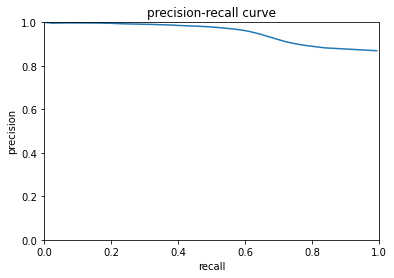

In [18]:
plt.ylim(0,1)
plt.xlim(0,1)

plt.plot(recalls, precisions)
plt.title('precision-recall curve')
plt.ylabel('precision')
plt.xlabel('recall')